In [1]:
# Step 1. Import library and creds, upload data, prepare logging 
# Step 2. EDA - analyze data
# Step 3. Create new df with preprocessing(do pipeline or function)
# Step 4. Find best regressor
# Step 5. Tuning best regressor
# Extra: do logging by steps, calculate diff metrics

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os 
import requests

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind, mannwhitneyu, wilcoxon
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC, SVR
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor, RandomForestClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree


In [3]:
# URL = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-11-03/ikea.csv'
# req = requests.get(URL)
# df = pd.read_csv(URL)

# 1. Loading data

In [4]:
def download_document(file_name, document_url):
    if os.path.exists(file_name):
        pass
    else:
        response = requests.get(document_url)
        if response.status_code == 200:
            with open(file_name, 'wb') as f:
                f.write(response.content)
            return f    

        else:
            print(f'Failed to download the document. Status code: {response.status_code}')


file_name = 'ikea.csv'
document_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-07-07/'
download_document(file_name, document_url)

In [5]:
row_df = pd.read_csv(file_name)
df = row_df.copy()
df.sample(3)

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
1697,1697,59297438,JONAXEL,Chests of drawers & drawer units,140.0,No old price,True,https://www.ikea.com/sa/en/p/jonaxel-frame-wit...,No,"Frame with wire baskets/castors, ...",IKEA of Sweden,51.0,73.0,25.0
635,635,9188842,EKET,Bookcases & shelving units,414.0,No old price,True,https://www.ikea.com/sa/en/p/eket-wall-mounted...,Yes,"Wall-mounted cabinet combination, ...",IKEA of Sweden/Jon Karlsson,35.0,120.0,105.0
1831,1831,80089239,TROFAST,Children's furniture,10.0,No old price,True,https://www.ikea.com/sa/en/p/trofast-storage-b...,No,"Storage box, 42x30x10 cm",Studio Copenhagen,NaN,10.0,30.0


#  2. EDA


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3694 entries, 0 to 3693
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         3694 non-null   int64  
 1   item_id            3694 non-null   int64  
 2   name               3694 non-null   object 
 3   category           3694 non-null   object 
 4   price              3694 non-null   float64
 5   old_price          3694 non-null   object 
 6   sellable_online    3694 non-null   bool   
 7   link               3694 non-null   object 
 8   other_colors       3694 non-null   object 
 9   short_description  3694 non-null   object 
 10  designer           3694 non-null   object 
 11  depth              2231 non-null   float64
 12  height             2706 non-null   float64
 13  width              3105 non-null   float64
dtypes: bool(1), float64(4), int64(2), object(7)
memory usage: 378.9+ KB


In [7]:
df.duplicated().sum() # дублів немає. 

0

In [8]:
# дeякі товари повторюються у кількох категоріях
df['item_id'].duplicated().sum()

732

In [9]:
df[df['item_id']==79241940]

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
41,41,79241940,NORRÅKER / NORRÅKER,Bar furniture,1385.0,No old price,True,https://www.ikea.com/sa/en/p/norraker-norraker...,No,"Bar table and 2 bar stools, 7...",J Karlsson/N Karlsson,NaN,104.0,74.0
1100,1100,79241940,NORRÅKER / NORRÅKER,Café furniture,1385.0,No old price,True,https://www.ikea.com/sa/en/p/norraker-norraker...,No,"Bar table and 2 bar stools, 7...",J Karlsson/N Karlsson,NaN,104.0,74.0
1469,1469,79241940,NORRÅKER / NORRÅKER,Chairs,1385.0,No old price,True,https://www.ikea.com/sa/en/p/norraker-norraker...,No,"Bar table and 2 bar stools, 7...",J Karlsson/N Karlsson,NaN,104.0,74.0
3164,3164,79241940,NORRÅKER / NORRÅKER,Tables & desks,1385.0,No old price,True,https://www.ikea.com/sa/en/p/norraker-norraker...,No,"Bar table and 2 bar stools, 7...",J Karlsson/N Karlsson,NaN,104.0,74.0


In [10]:
# вважаю за потрібне видалити такі дублі
df.drop_duplicates(subset=['item_id'],inplace = True)
# видаляємо фічі, що не будуть використані при аналізі
df.drop(['Unnamed: 0','link'], axis=1, inplace = True)

In [11]:
# фіча 'old_price' позначена як object, хоча точно має бути числом, тож дивлюсь які там є значення
df['old_price']

0       No old price
1       No old price
2       No old price
3       No old price
4       No old price
            ...     
3688    No old price
3689          SR 820
3690        SR 1,755
3691        SR 1,050
3692        SR 3,130
Name: old_price, Length: 2962, dtype: object

Тож стає зрозуміло, що для фічі 'old_price' треба замінити значення типу "SR 50/4 pack" і 'No old price' на 'price', для інших рядків залишити лише цифри (прибрати пробіли, SR і коми). 
Зроблю на етапі Feature engeneering

In [12]:
# функція для обробки фічі old_price (прибрати "SK", замінити 'No old price' і ціни з закінченням 'pack'  
# на значення поточної ціни)
def fix_old_price(df): 
        
    if df['old_price']  == 'No old price':
        return df['price']

    elif df['old_price'][-4:] != 'pack':
            return float(str(df['old_price'])[3:].replace(',',''))
        
    else:
        return df['price']
    

df['old_price'] = df.apply(fix_old_price, axis=1)
df['old_price']

0        265.0
1        995.0
2       2095.0
3         69.0
4        225.0
         ...  
3688    2045.0
3689     820.0
3690    1755.0
3691    1050.0
3692    3130.0
Name: old_price, Length: 2962, dtype: float64

In [13]:
# фіча 'short_description' містить розміри, які відрізняються від вказаних у відповідних фічах. 
df[df['depth'].isna()][['depth', 'height', 'width','short_description']]

,depth,height,width,short_description
0,NaN,99.0,51.0,"Bar table, in/outdoor, 51x51 cm"
1,NaN,105.0,80.0,"Bar table, 140x80 cm"
2,NaN,NaN,NaN,Bar table and 4 bar stools
9,NaN,NaN,NaN,Bar table and 4 bar stools
15,NaN,105.0,70.0,"Table, 130x70/105 cm"
...,...,...,...,...
3600,NaN,236.0,270.0,"Corner wardrobe, 113/271/113x..."
3607,NaN,236.0,160.0,"Corner wardrobe, 210/160x236 cm"
3614,NaN,236.0,162.0,"Corner wardrobe, 160/163x236 cm"
3626,NaN,NaN,NaN,"Open shelving unit, 160x40x63 cm"


In [14]:
# Можна було б заповнити відсутні, але немає впевненості, 
# (а) чи корректні(бо відрізняються від табличних), 
# (б) що саме з тих параметрів що 
# видаляю цю фічу
df.drop('short_description', axis=1, inplace = True)

In [15]:
# Бачу, що відсутні значення для фіч габаритів. Перевірю скільки відсутніх. 
df.groupby('category')[['width', 'height', 'depth']].apply(lambda x: x.isna().sum())

,width,height,depth
category,,,
Bar furniture,10,12,20
Beds,23,51,125
Bookcases & shelving units,56,106,95
Cabinets & cupboards,3,9,16
Café furniture,3,2,8
Chairs,85,182,194
Chests of drawers & drawer units,0,2,3
Children's furniture,5,12,23
Nursery furniture,0,5,5


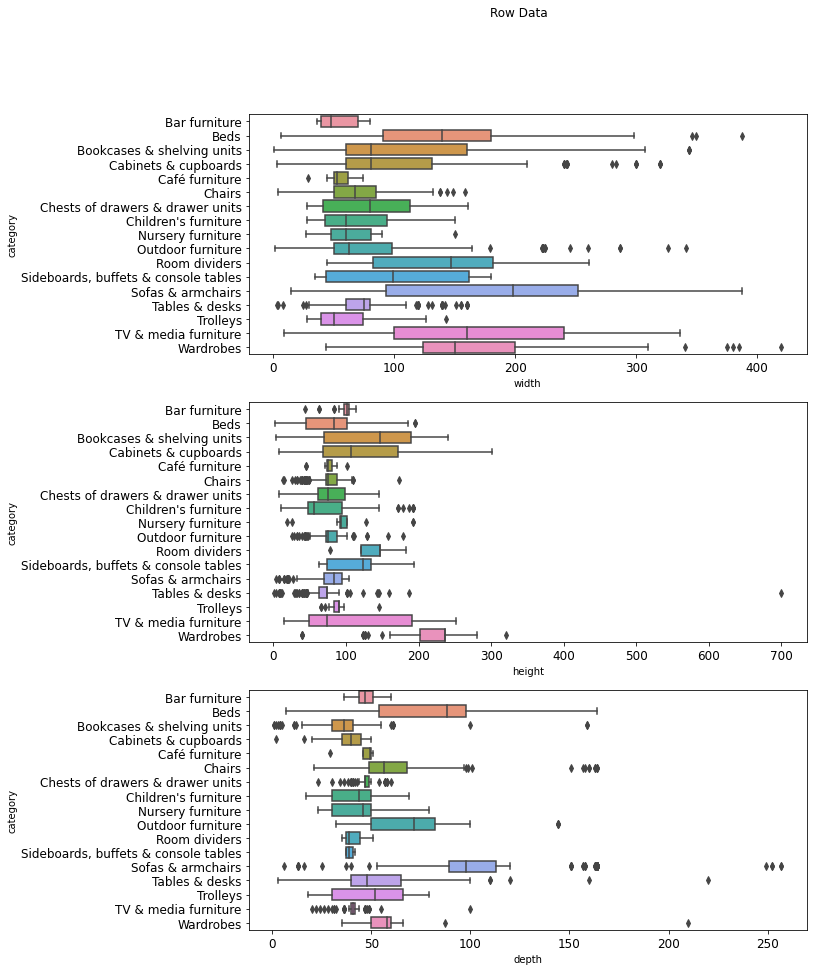

In [16]:
# подивлюсь на розподіл цих величин, аби зрозуміти як краще їх заповнити
fig, ax = plt.subplots(3, 1, figsize=(10,15))
fig.suptitle('Row Data')
sns.boxplot(ax = ax[0], data = df, x="width", y="category").tick_params(labelsize=12)
sns.boxplot(ax = ax[1], data = df, x="height", y="category").tick_params(labelsize=12)
sns.boxplot(ax = ax[2], data = df, x="depth", y="category").tick_params(labelsize=12);

Оскільки є викиди, і подекуди значні, то краще заміняти пропущені значення 'width', 'height', 'depth' на медіану у відповідних категоріях (припускаю, що більшість шаф близькі за розміром, хоча є і виключення). 

In [17]:
df[['width', 'height', 'depth']] = df.groupby(['category'])['width', 'height', 'depth'].\
                                                transform(lambda x: x.fillna(x.median()))

In [18]:
# проінспектую фічі = object
columns = df.select_dtypes(include = 'object').columns
for i in range(len(columns)):
    print('-------------------------------------------')
    print(df[columns[i]].name)
    print('-------------------------------------------')
    print(f'{df[columns[i]].value_counts()} \n\n')



-------------------------------------------
name
-------------------------------------------
BESTÅ                115
PAX                  111
GRÖNLID               82
IVAR                  66
BEKANT                64
                    ... 
URBAN                  1
LAIVA                  1
BLÅMES                 1
GNEDBY                 1
PAX / MEHAMN/AULI      1
Name: name, Length: 607, dtype: int64 


-------------------------------------------
category
-------------------------------------------
Bookcases & shelving units              548
Chairs                                  438
Sofas & armchairs                       380
Tables & desks                          370
Wardrobes                               220
Beds                                    208
Outdoor furniture                       197
Cabinets & cupboards                    187
Chests of drawers & drawer units        111
TV & media furniture                     89
Children's furniture                     84
Bar furnit

Тут одразу можна помітити наступне:
- поле name: є лінійки з 1 товаром, тож при аналізі лінійок, (можливо) варто їх прибрати
- поле old_price: треба перетворити на числове - опрацювати текстові значення
- поле  designer: треба вдалити помилково туди занесені описи, і по можливості ізолювати кожного дизайнера від сторонноо тексту. 
Вирішу ці проблеми на етапі feature engineering

In [19]:
df['designer'].unique()

array(['Nicholai Wiig Hansen', 'Francis Cayouette', 'Henrik Preutz',
       'Marcus Arvonen', 'Carina Bengs', 'K Hagberg/M Hagberg',
       'Sarah Fager', 'Ehlén Johansson', 'Nike Karlsson',
       'Maja Ganszyniec', 'Karl Malmvall',
       'John/Jonas/Petrus/Paul/Caroline', 'Nike Karlsson/Maja Ganszyniec',
       'J Karlsson/N Karlsson', 'IKEA of Sweden/Karl Malmvall',
       'IKEA of Sweden', 'Nike Karlsson/J Karlsson/N Karlsson',
       'Ola Wihlborg', 'IKEA of Sweden/Tina Christensen',
       'IKEA of Sweden/K Hagberg/M Hagberg',
       'Ola Wihlborg/IKEA of Sweden',
       '504.689.53 Small and easy-to-place chair-bed which can easily be converted into a single bed.The storage space under the seat has room for bedlinen or other things.Just as nice to look at from all sides – perfect to place in the middle of the room or use as a room divider.The cushion cover is easy to keep clean and fresh, as you can take it off and machine-wash it.Easy to assemble.1 cushion included.',
       '

In [20]:
def cleanDesigners(value):
        
    if value[:3].isdigit():
        return 'No data'
    
    elif value =='IKEA of Sweden':
        return 'No data'
        
    elif "IKEA of Sweden/" in value:     
        return value.replace('IKEA of Sweden/','')
     
    elif "/IKEA of Sweden" in value:     
        return value.replace('/IKEA of Sweden','')
    else:
        return value
            
df['designer'] = df['designer'].apply(cleanDesigners)

In [21]:
df[df['designer']!= 'No data']['designer'].value_counts().head(10)

Ehlén Johansson                  274
Ola Wihlborg                     159
Jon Karlsson                     152
Francis Cayouette                143
K Hagberg/M Hagberg              119
Henrik Preutz                     77
Ebba Strandmark                   70
Carina Bengs                      68
Eva Lilja Löwenhielm              60
K Malmvall/E Lilja Löwenhielm     55
Name: designer, dtype: int64

In [22]:
df_t = df[df['designer']!= 'No data']['designer'].value_counts().head(10).to_frame().reset_index()
df_t

,index,designer
0,Ehlén Johansson,274
1,Ola Wihlborg,159
2,Jon Karlsson,152
3,Francis Cayouette,143
4,K Hagberg/M Hagberg,119
5,Henrik Preutz,77
6,Ebba Strandmark,70
7,Carina Bengs,68
8,Eva Lilja Löwenhielm,60
9,K Malmvall/E Lilja Löwenhielm,55


In [23]:
df_t = df[df['designer']!= 'No data']['designer'].value_counts().to_frame().reset_index()


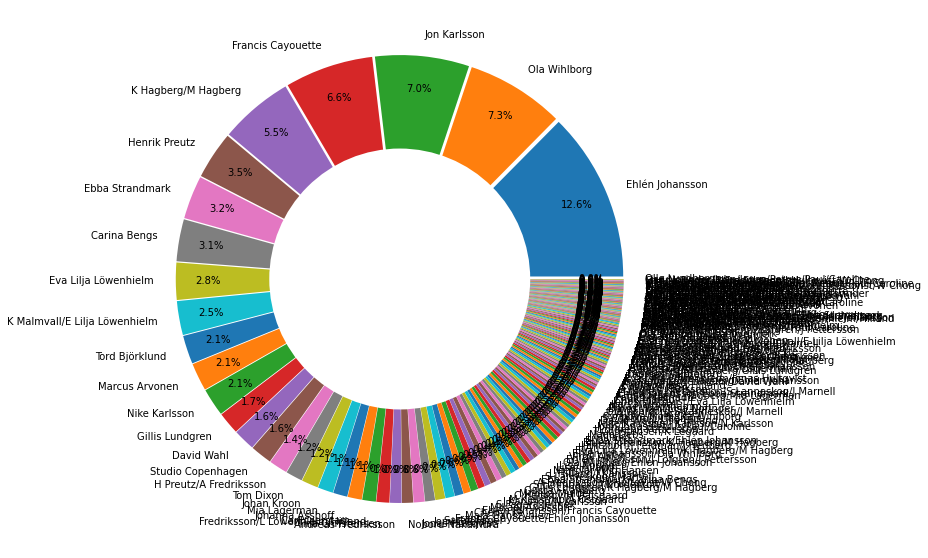

In [24]:
df_t = df[df['designer']!= 'No data']['designer'].value_counts().to_frame().reset_index()

explode = [0.03 for number in range(len(df_t))]
plt.figure(figsize=(10,10))
plt.pie(df_t['designer'], labels=df_t['index'],autopct='%3.1f%%', pctdistance=0.85,
        explode=explode)
centre_circle = plt.Circle((0, 0), 0.60, fc='#ffffff') # центральне коло, аби вийшов donut
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.show()

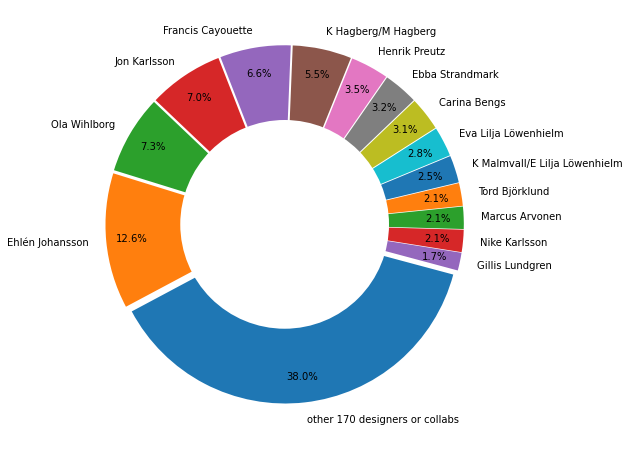

In [25]:
df_t = df[df['designer']!= 'No data']['designer'].value_counts().to_frame().reset_index()

df_t['label_'] = df_t.apply((lambda x: x['index'] if x['designer']>35 else 'other 170 designers or collabs'), axis=1)

df_t = df_t.groupby('label_').sum().reset_index().sort_values(by=['designer'],ascending = False)


explode = [0.03 for number in range(len(df_t))]
plt.figure(figsize=(8,8))
plt.pie(df_t['designer'], labels=df_t['label_'],autopct='%3.1f%%', pctdistance=0.85,
        explode=explode, startangle = -15,counterclock = False)
centre_circle = plt.Circle((0, 0), 0.60, fc='#ffffff') # центральне коло, аби вийшов donut
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.show()

In [26]:
df_t = df[df['designer']!= 'No data']['designer'].value_counts().to_frame().reset_index()
df_t['label_'] = df_t.apply((lambda x: x['index'] if x['designer']>34 else 'other 170 designers or collabs'), axis=1)
df_t = df_t.groupby('label_').sum().reset_index().sort_values(by=['designer'],ascending = False)
df_t

,label_,designer
16,other 170 designers or collabs,758
3,Ehlén Johansson,274
13,Ola Wihlborg,159
8,Jon Karlsson,152
5,Francis Cayouette,143
9,K Hagberg/M Hagberg,119
7,Henrik Preutz,77
2,Ebba Strandmark,70
0,Carina Bengs,68
4,Eva Lilja Löwenhielm,60


тобто можна виділити топ15 дизайнерів .

In [27]:
# проінспектую фічі = int\float
df.describe()

,item_id,price,old_price,depth,height,width
count,2.962000e+03,2962.000000,2962.000000,2962.000000,2962.000000,2962.000000
mean,4.877244e+07,1108.722552,1161.330858,58.650068,102.369345,110.726874
std,2.896535e+07,1393.576103,1470.418936,27.887632,57.782409,71.719684
min,5.848700e+04,3.000000,3.000000,1.000000,1.000000,1.000000
25%,2.039630e+07,200.000000,205.000000,41.000000,74.000000,60.000000
50%,4.928075e+07,570.000000,595.000000,50.000000,83.000000,81.000000
75%,7.042306e+07,1475.000000,1543.750000,71.500000,124.000000,150.000000
max,9.993262e+07,9585.000000,9985.000000,257.000000,700.000000,420.000000


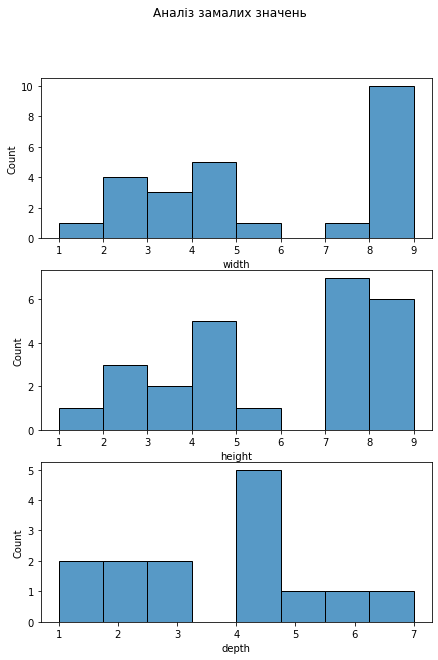

In [28]:
# видно, що для габаритів підозріло замалий мінімум - 1 см, і завеликі максимуми, як для меблів(7 метрів). треба дослідити
# спочатку мінімум
fig, ax = plt.subplots(3, 1, figsize=(7,10))
fig.suptitle('Аналіз замалих значень')
sns.histplot(ax = ax[0], data=df[df['width']<10], x="width", bins = 8)
sns.histplot(ax = ax[1], data=df[df['height']<10], x="height", bins = 8)
sns.histplot(ax = ax[2], data=df[df['depth']<10], x="depth", bins = 8);


In [29]:
df[(df['depth'] < 10) | (df['height'] < 10) | (df['width'] < 10)] \
                                        ['category'].value_counts()

Bookcases & shelving units          23
Tables & desks                       9
Beds                                 6
Sofas & armchairs                    5
TV & media furniture                 3
Cabinets & cupboards                 2
Chests of drawers & drawer units     2
Outdoor furniture                    2
Chairs                               1
Name: category, dtype: int64

In [30]:
row_df[((row_df['category'] == 'Beds') | (row_df['category'] == 'Sofas & armchairs')) & \
       ((row_df['depth'] < 10) | (row_df['height'] < 10) | (row_df['width'] < 10))]

,Unnamed: 0,item_id,name,category,price,old_price,sellable_online,link,other_colors,short_description,designer,depth,height,width
103,103,360484,UTÅKER,Beds,695.0,No old price,True,https://www.ikea.com/sa/en/p/utaker-stackable-...,No,"Stackable bed, 80x200 cm",Henrik Preutz,NaN,2.0,83.0
108,108,30160209,LURÖY,Beds,100.0,No old price,True,https://www.ikea.com/sa/en/p/luroey-slatted-be...,Yes,"Slatted bed base, 80x200 cm",IKEA of Sweden,NaN,4.0,80.0
130,130,30099293,VIKARE,Beds,95.0,No old price,True,https://www.ikea.com/sa/en/p/vikare-guard-rail...,No,Guard rail,IKEA of Sweden,NaN,7.0,NaN
152,152,39227837,UTÅKER,Beds,1285.0,No old price,True,https://www.ikea.com/sa/en/p/utaker-stackable-...,Yes,"Stackable bed with 2 mattresses, ...",IKEA of Sweden/Henrik Preutz,NaN,2.0,83.0
185,185,20299688,BRENNÅSEN,Beds,30.0,SR 50/4 pack,True,https://www.ikea.com/sa/en/p/brennasen-leg-bla...,No,"Leg, 10 cm",Ola Wihlborg,7.0,NaN,7.0
213,213,20249896,SVÄRTA,Beds,300.0,SR 375,True,https://www.ikea.com/sa/en/p/svaerta-desk-top-...,No,Desk top,Tord Björklund,88.0,2.0,200.0
2314,2314,59135653,SÖDERHAMN,Sofas & armchairs,175.0,SR 200,True,https://www.ikea.com/sa/en/p/soederhamn-armres...,Yes,Armrest,Ola Wihlborg,6.0,53.0,82.0
2404,2404,79279396,VALLENTUNA,Sofas & armchairs,320.0,SR 400,True,https://www.ikea.com/sa/en/p/vallentuna-back-r...,Yes,"Back rest, 100x80 cm",IKEA of Sweden/Fredriksson/L Löwenhielm/Hilland,13.0,4.0,100.0
2423,2423,30105901,POÄNG,Sofas & armchairs,785.0,No old price,True,https://www.ikea.com/sa/en/p/poaeng-armchair-c...,Yes,Armchair cushion,Noboru Nakamura,NaN,7.0,56.0
2565,2565,10052362,POÄNG,Sofas & armchairs,150.0,SR 250,True,https://www.ikea.com/sa/en/p/poaeng-footstool-...,No,Footstool cushion,Noboru Nakamura,NaN,7.0,60.0


Зрозуміло, що кожний випадок унікальний - десь то дійсно допустиме значення(для подушки, наприклад, або рейкової основи для ліжка), але десь - явно некорректний. Можливо, десь вказано у см, а десь у м. 

Тобто систиматизувати корректну очистку таких даних можна, але треба долучити NLP у поєднанні з AI. 

Точково виправити ці данні вручну тако ж не варіант - бо система, навчана на синтетичних даних, погано працюватиме на "живих".
Тож поки залишу як є. При моделюванні спробую додатково на датасеті, де такі показники заменю на q1 або q3.

Але в роботі я пішла б розбиратись з відповідальною за каталог колегою, аби дані вносились коректні.

Аналогічну логіку застосую до завеликих розмірів(висота 700, наприклад).


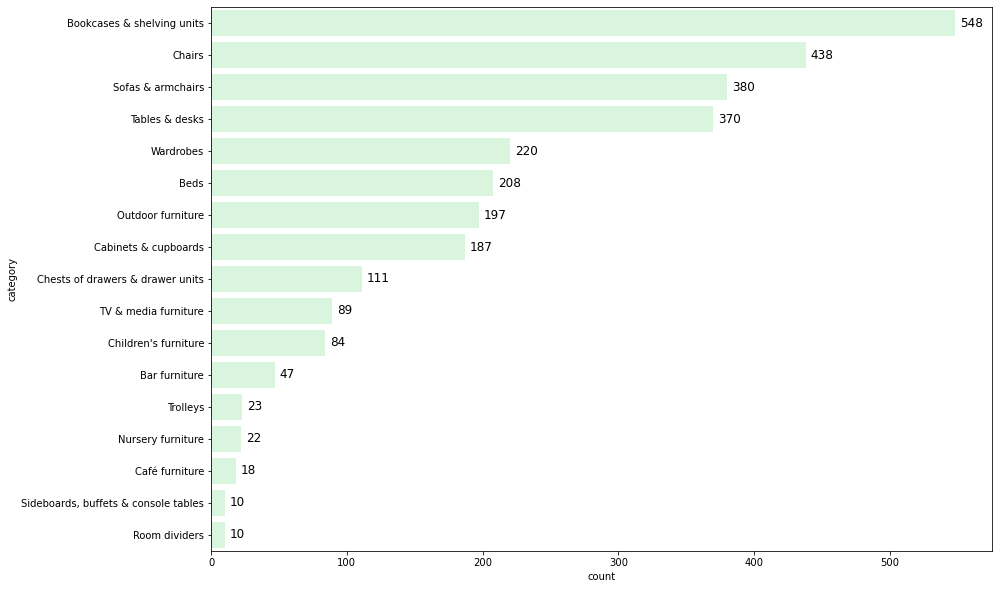

In [31]:
order = df['category'].value_counts().index
plt.figure(figsize=[14, 10])
ax = sns.countplot(data=df, y='category', order=order, color='#abf7b7', alpha = 0.5)
ax.bar_label(ax.containers[0], fontsize=12, padding = 5);

1. Є значний перекос у кількості представників категорій, тож розбивка на train і test має бути стратифікована.
2. Крім того, можна помітити, що деякі категорії можна обєднати, наприклад: 
+ 'Trolleys'  і 'Sideboards, buffets & console tables'
+ 'Bar furniture' і 'Café furniture'

Тож у вигляді експерименту, спробую на такому дата сеті окремо




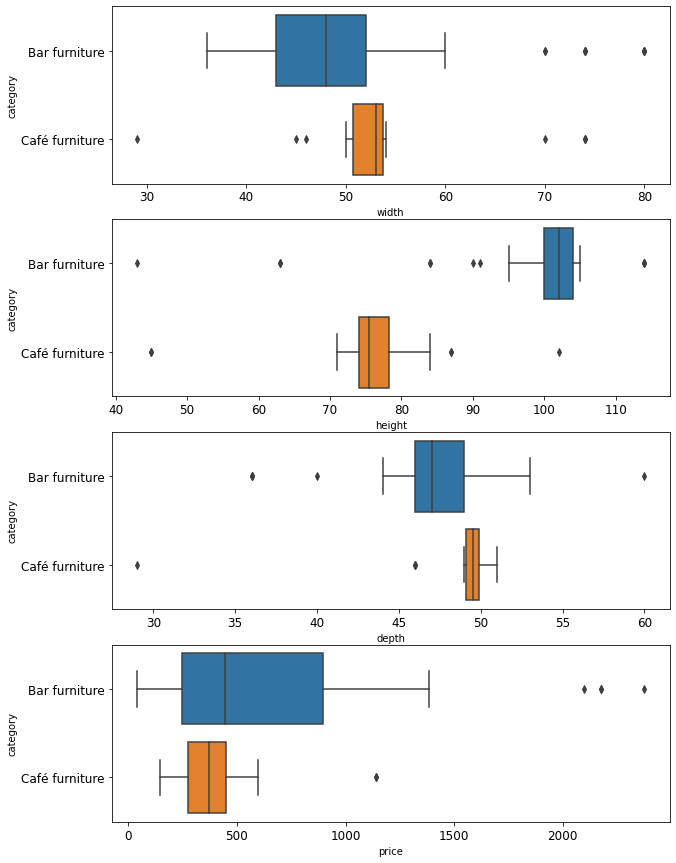

In [32]:
# подивлюсь на розподіл цих величин, аби зрозуміти як краще їх заповнити
fig, ax = plt.subplots(4, 1, figsize=(10,15))
sns.boxplot(ax = ax[0], data = df[(df['category']=='Café furniture')| (df['category'] == 'Bar furniture')], x="width", y="category").tick_params(labelsize=12)
sns.boxplot(ax = ax[1], data = df[(df['category']=='Café furniture')| (df['category'] == 'Bar furniture')], x="height", y="category").tick_params(labelsize=12)
sns.boxplot(ax = ax[2], data = df[(df['category']=='Café furniture')| (df['category'] == 'Bar furniture')], x="depth", y="category").tick_params(labelsize=12)
sns.boxplot(ax = ax[3], data = df[(df['category']=='Café furniture')| (df['category'] == 'Bar furniture')], x="price", y="category").tick_params(labelsize=12)


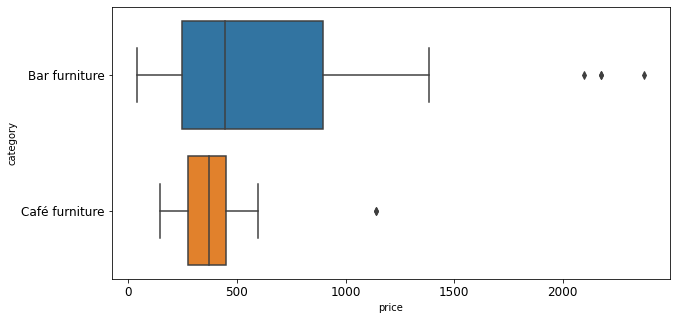

In [33]:
plt.figure(figsize=[10, 5])
sns.boxplot(data = df[(df['category']=='Café furniture')| (df['category'] == 'Bar furniture')], \
            x="price", y="category").tick_params(labelsize=12)

In [34]:
df[df['category'] == 'Bar furniture'].describe()

,item_id,price,old_price,depth,height,width
count,4.700000e+01,47.000000,47.000000,47.000000,47.000000,47.000000
mean,4.257338e+07,679.553191,707.340426,46.957447,98.702128,51.893617
std,3.124724e+07,604.600148,634.871821,4.288293,12.811196,13.368090
min,1.217660e+05,40.000000,40.000000,36.000000,43.000000,36.000000
25%,1.484891e+07,245.000000,270.000000,46.000000,100.000000,43.000000
50%,4.033900e+07,445.000000,445.000000,47.000000,102.000000,48.000000
75%,6.977516e+07,895.500000,995.000000,49.000000,104.000000,52.000000
max,9.932392e+07,2375.000000,2375.000000,60.000000,114.000000,80.000000


In [35]:
df[df['category']=='Café furniture'].describe()

,item_id,price,old_price,depth,height,width
count,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000
mean,4.273364e+07,426.722222,444.111111,48.000000,74.888889,55.000000
std,3.117203e+07,283.589348,291.053035,4.982322,13.175909,11.499361
min,2.460780e+05,145.000000,145.000000,29.000000,45.000000,29.000000
25%,1.264293e+07,275.000000,275.000000,49.125000,74.000000,50.750000
50%,4.484438e+07,370.000000,370.000000,49.500000,75.500000,53.000000
75%,6.038326e+07,450.000000,450.000000,49.875000,78.250000,53.750000
max,9.042898e+07,1140.000000,1140.000000,51.000000,102.000000,74.000000


In [36]:
df[df['category'] == 'Trolleys'].describe()

,item_id,price,old_price,depth,height,width
count,2.300000e+01,23.000000,23.000000,23.000000,23.000000,23.000000
mean,4.593431e+07,748.869565,764.434783,51.217391,87.826087,61.130435
std,3.024706e+07,703.491701,702.550731,13.286892,15.278185,32.499377
min,5.848700e+04,39.000000,39.000000,18.000000,65.000000,28.000000
25%,2.039572e+07,160.000000,160.000000,52.000000,84.000000,39.500000
50%,4.039166e+07,537.000000,645.000000,52.000000,90.000000,50.000000
75%,7.516982e+07,1245.000000,1245.000000,52.000000,90.000000,74.500000
max,9.044662e+07,2295.000000,2295.000000,79.000000,146.000000,143.000000


In [37]:
df[df['category'] == 'Sideboards, buffets & console tables'].describe()

,item_id,price,old_price,depth,height,width
count,1.000000e+01,10.000000,10.000000,10.000000,10.000000,10.000000
mean,3.868337e+07,1013.000000,1013.000000,39.100000,113.700000,105.200000
std,3.325240e+07,587.864308,587.864308,1.852926,42.300644,62.205395
min,1.050640e+05,295.000000,295.000000,37.000000,63.000000,35.000000
25%,9.520998e+06,495.000000,495.000000,37.500000,74.250000,43.500000
50%,3.485495e+07,927.500000,927.500000,39.000000,123.000000,99.000000
75%,6.955051e+07,1511.250000,1511.250000,39.750000,134.000000,162.000000
max,8.926584e+07,1950.000000,1950.000000,42.000000,193.000000,180.000000


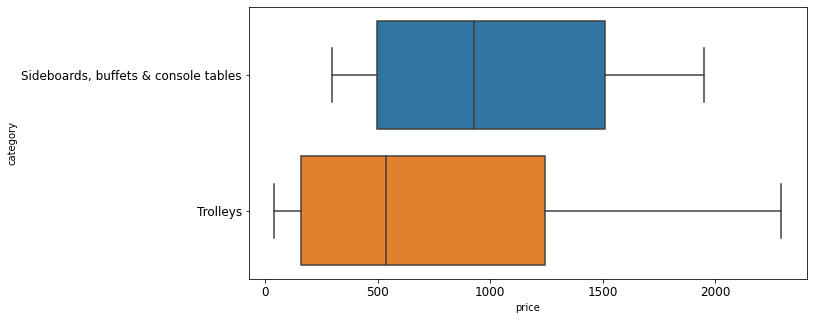

In [38]:
plt.figure(figsize=[10, 5])
sns.boxplot( data = df[(df['category'] == 'Trolleys') | (df['category'] == 'Sideboards, buffets & console tables')], \
            x="price", y="category").tick_params(labelsize=12)

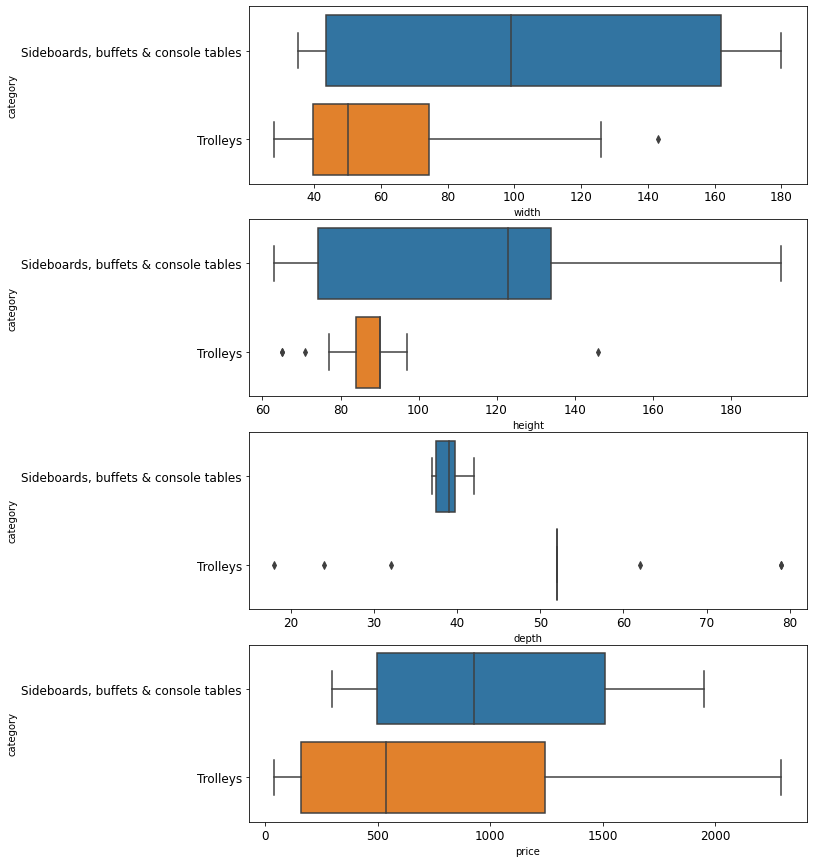

In [39]:
# подивлюсь на розподіл цих величин, аби зрозуміти як краще їх заповнити
fig, ax = plt.subplots(4, 1, figsize=(10,15))
sns.boxplot(ax = ax[0], data = df[(df['category'] == 'Trolleys') | (df['category'] == 'Sideboards, buffets & console tables')], x="width", y="category").tick_params(labelsize=12)
sns.boxplot(ax = ax[1], data = df[(df['category'] == 'Trolleys') | (df['category'] == 'Sideboards, buffets & console tables')], x="height", y="category").tick_params(labelsize=12)
sns.boxplot(ax = ax[2], data = df[(df['category'] == 'Trolleys') | (df['category'] == 'Sideboards, buffets & console tables')], x="depth", y="category").tick_params(labelsize=12)
sns.boxplot(ax = ax[3], data = df[(df['category'] == 'Trolleys') | (df['category'] == 'Sideboards, buffets & console tables')], x="price", y="category").tick_params(labelsize=12)


In [40]:
df_category_concat = df.copy()
df_category_concat['category'] = np.where((df_category_concat['category'] == 'Café furniture') | (df_category_concat['category'] == 'Bar furniture'), 'Cafe\Bar', df_category_concat['category'])
df_category_concat['category'] = np.where((df_category_concat['category'] == 'Trolleys') | (df_category_concat['category'] == 'Sideboards, buffets & console tables'), 'Sideboards\Trolleys', df_category_concat['category'])


<AxesSubplot:xlabel='price'>

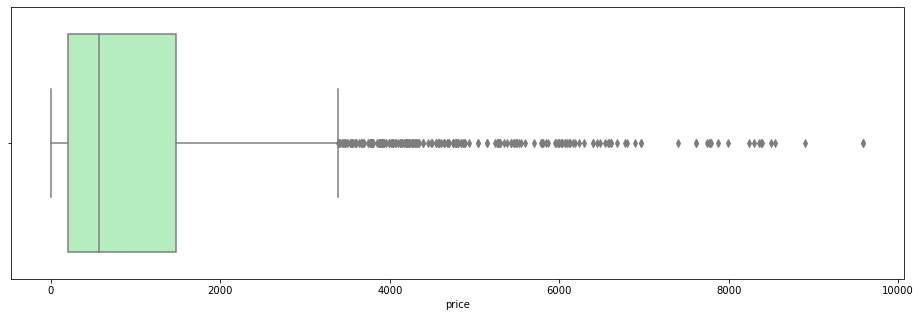

In [41]:
# тепер дивлюсь на ціну
plt.figure(figsize=[16, 5])
sns.boxplot(data = df, x="price", color='#abf7b7')


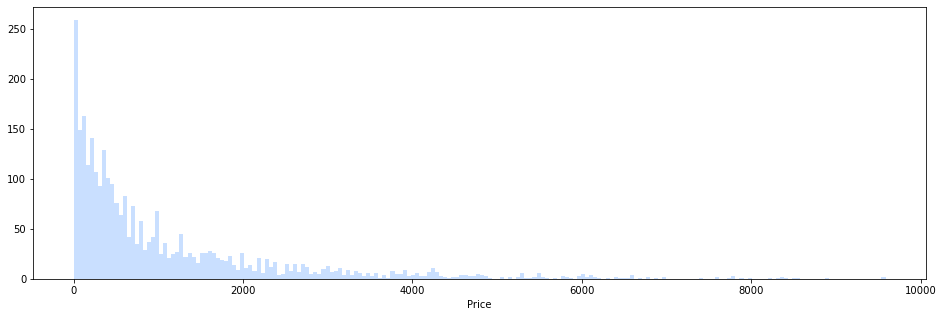

In [42]:

plt.figure(figsize=[16, 5])
plt.hist(data=df, x='price',bins=200, color='#94c0ff', alpha = 0.5)

plt.xlabel('Price');

Схоже на логорифмічний розподіл, з довгим хвостомі дуже багато значень пора q3. 
Проте, слід пам'ятати, що це ціна - і це логічно, мати різні цінові категоріх товарів. 
Подивимось на значення ціни > 8000

Товарів з ціною понад 8000 маємо
10


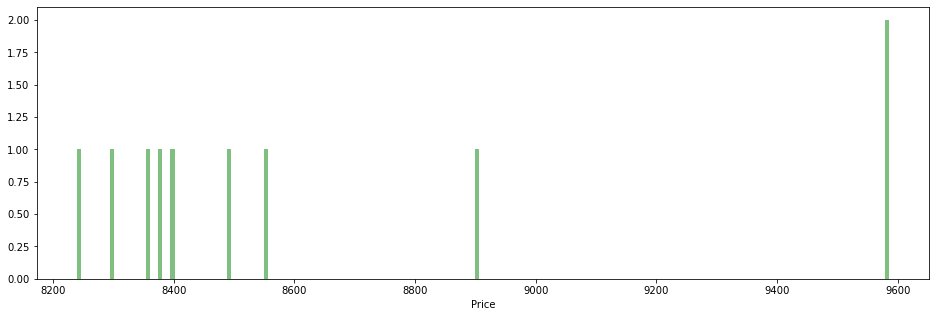

In [43]:
plt.figure(figsize=[16, 5])
print(f'Товарів з ціною понад 8000 маємо')
print(df[df['price']>8000].shape[0])
plt.hist(data=df[df['price']>8000], x='price',bins=200, color='green', alpha = 0.5)

plt.xlabel('Price');

Поексперементую з видаленням n товарів(скільки визначу окремо) з найбільших цін

In [44]:
# експериментальний дата сет - видалю позиції дорожчі 8000\6000
df_price_8000 = df[df['price']<8000].copy()
df_price_6000 = df[df['price']<6000].copy()


In [45]:
# тепер можна подивтись на взаэмозв'язок ціни і знижки 
# створюю фічі чи був застосований дисконт та розмір дисконту у %
df['discont'] = 100 - df['price']/df['old_price']*100
df['discounted'] = (df['discont'] >0).astype(int)

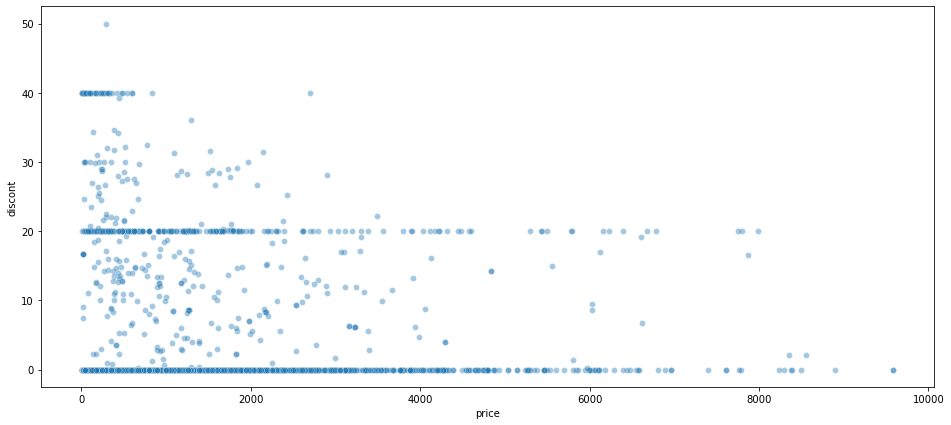

In [46]:
plt.figure(figsize=[16, 7])
sns.scatterplot(data=df, x="price", y="discont", alpha=0.4);

Можна зробити висновок, що знижку застосовують не часто - багато товарів з 0 знижкою.
Частіше застосовують знижку на 20% і 40%, і в більшості випадків для дешевших товарів.
Знижки бувають 2х видів: "на x %" і "на x доларів", оскільки чітко видно з розкиду значень між "поверхами" чітких відсотків. 
Чим дорожчий товар, тим рідше застосувується знижка і тим вона меньша - для найдорожчих товарів знижка не застосовується взагалі, а для товарів, дорожчих 3800 (приблизно) знижка не буває більшою 20 %

Проте для дешевших товарів багато знижок до 20% 

<Figure size 1440x1440 with 0 Axes>

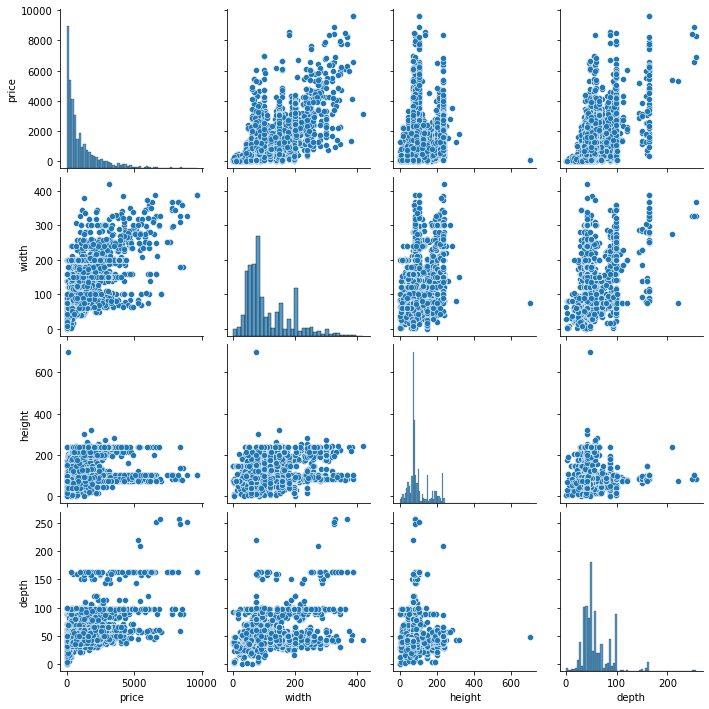

In [47]:
plt.figure(figsize=[20, 20])
sns.pairplot(df[['price','width', 'height', 'depth']], height=2.5)

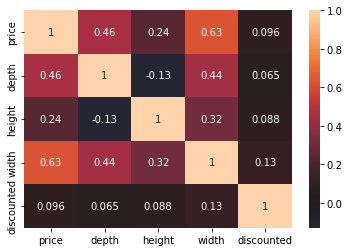

In [48]:
sns.heatmap(df[['price', 'depth', 'height', 'width','discounted']].corr(), xticklabels= df[['price', 'depth', 'height', 'width','discounted']].corr().columns,
            yticklabels= df[['price', 'depth', 'height', 'width','discounted']].corr().columns, center= 0, annot= True);

In [49]:
# дивлюсь розподіл 'sellable_online'. 
df['sellable_online'].value_counts(normalize = True)


True     0.993585
False    0.006415
Name: sellable_online, dtype: float64

In [50]:
df_t = df['sellable_online'].value_counts().to_frame().reset_index()
df_t

,index,sellable_online
0,True,2943
1,False,19


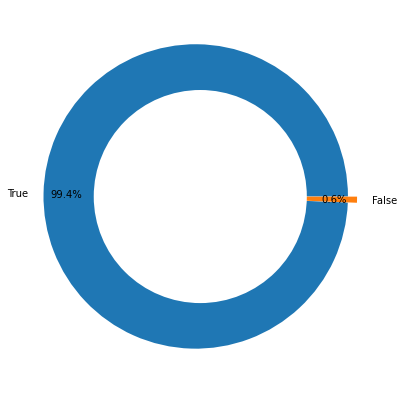

In [51]:
df_t = df['sellable_online'].value_counts().to_frame().reset_index()

explode = [0.06 for number in range(len(df_t))]
plt.figure(figsize=(7,7))
plt.pie(df_t['sellable_online'], labels=df_t['index'],autopct='%3.1f%%', pctdistance=0.85,
        explode=[0.03,0.03])
centre_circle = plt.Circle((0, 0), 0.70, fc='#ffffff') # центральне коло, аби вийшов donut
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.show()

Дуже перекошені дані - вважаю нерелевантною фічею для аналізу

In [52]:
df.drop('sellable_online', axis=1, inplace = True)

In [53]:
# дивлюсь розподіл 'other_colors'. 
df['other_colors'].value_counts(normalize = True)

No     0.552667
Yes    0.447333
Name: other_colors, dtype: float64

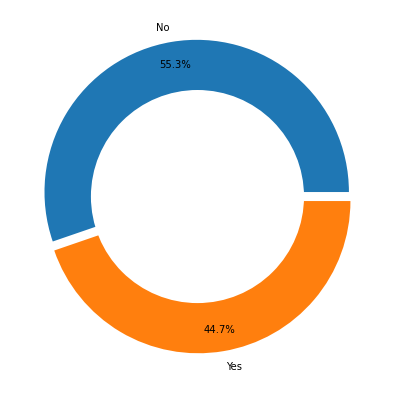

In [54]:
df_t = df['other_colors'].value_counts().to_frame().reset_index()

explode = [0.06 for number in range(len(df_t))]
plt.figure(figsize=(7,7))
plt.pie(df_t['other_colors'], labels=df_t['index'],autopct='%3.1f%%', pctdistance=0.85,
        explode=[0.03,0.03])
centre_circle = plt.Circle((0, 0), 0.70, fc='#ffffff') # центральне коло, аби вийшов donut
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
 
plt.show()

Ця фіча може виявитись корисною. 

In [55]:
# скалюємо числові фічі 

scaler = StandardScaler()

df[['width', 'height', 'depth']] = scaler.fit_transform(df[['width', 'height', 'depth']])

df

,item_id,name,category,price,old_price,other_colors,designer,depth,height,width,discont,discounted
0,90420332,FREKVENS,Bar furniture,265.0,265.0,No,Nicholai Wiig Hansen,-0.417821,-0.058321,-0.832923,0.000000,0
1,368814,NORDVIKEN,Bar furniture,995.0,995.0,No,Francis Cayouette,-0.417821,0.045535,-0.428502,0.000000,0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,2095.0,No,Francis Cayouette,-0.417821,-0.006393,-0.874759,0.000000,0
3,80155205,STIG,Bar furniture,69.0,69.0,Yes,Henrik Preutz,-0.310228,-0.041012,-0.707413,0.000000,0
4,30180504,NORBERG,Bar furniture,225.0,225.0,No,Marcus Arvonen,0.048414,-1.027637,-0.512176,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3688,89330653,PAX / MEHAMN/AULI,Wardrobes,2045.0,2045.0,No,Ehlén Johansson,0.263600,2.313043,1.244961,0.000000,0
3689,99157902,ELVARLI,Wardrobes,750.0,820.0,No,Ehlén Johansson,-0.310228,2.313043,-0.275102,8.536585,1
3690,9158152,ELVARLI,Wardrobes,1572.0,1755.0,No,Ehlén Johansson,-0.310228,2.313043,0.338502,10.427350,1
3691,59157541,ELVARLI,Wardrobes,924.0,1050.0,No,Ehlén Johansson,-0.310228,2.313043,0.896323,12.000000,1


In [56]:
df['category'] = df['category'].astype('category')
df['category_code']= df['category'].cat.codes
df

,item_id,name,category,price,old_price,other_colors,designer,depth,height,width,discont,discounted,category_code
0,90420332,FREKVENS,Bar furniture,265.0,265.0,No,Nicholai Wiig Hansen,-0.417821,-0.058321,-0.832923,0.000000,0,0
1,368814,NORDVIKEN,Bar furniture,995.0,995.0,No,Francis Cayouette,-0.417821,0.045535,-0.428502,0.000000,0,0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,2095.0,No,Francis Cayouette,-0.417821,-0.006393,-0.874759,0.000000,0,0
3,80155205,STIG,Bar furniture,69.0,69.0,Yes,Henrik Preutz,-0.310228,-0.041012,-0.707413,0.000000,0,0
4,30180504,NORBERG,Bar furniture,225.0,225.0,No,Marcus Arvonen,0.048414,-1.027637,-0.512176,0.000000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3688,89330653,PAX / MEHAMN/AULI,Wardrobes,2045.0,2045.0,No,Ehlén Johansson,0.263600,2.313043,1.244961,0.000000,0,16
3689,99157902,ELVARLI,Wardrobes,750.0,820.0,No,Ehlén Johansson,-0.310228,2.313043,-0.275102,8.536585,1,16
3690,9158152,ELVARLI,Wardrobes,1572.0,1755.0,No,Ehlén Johansson,-0.310228,2.313043,0.338502,10.427350,1,16
3691,59157541,ELVARLI,Wardrobes,924.0,1050.0,No,Ehlén Johansson,-0.310228,2.313043,0.896323,12.000000,1,16


In [57]:
df['other_colors'] = df['other_colors'].astype('category')
df['other_colors_code']= df['other_colors'].cat.codes
df

,item_id,name,category,price,old_price,other_colors,designer,depth,height,width,discont,discounted,category_code,other_colors_code
0,90420332,FREKVENS,Bar furniture,265.0,265.0,No,Nicholai Wiig Hansen,-0.417821,-0.058321,-0.832923,0.000000,0,0,0
1,368814,NORDVIKEN,Bar furniture,995.0,995.0,No,Francis Cayouette,-0.417821,0.045535,-0.428502,0.000000,0,0,0
2,9333523,NORDVIKEN / NORDVIKEN,Bar furniture,2095.0,2095.0,No,Francis Cayouette,-0.417821,-0.006393,-0.874759,0.000000,0,0,0
3,80155205,STIG,Bar furniture,69.0,69.0,Yes,Henrik Preutz,-0.310228,-0.041012,-0.707413,0.000000,0,0,1
4,30180504,NORBERG,Bar furniture,225.0,225.0,No,Marcus Arvonen,0.048414,-1.027637,-0.512176,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3688,89330653,PAX / MEHAMN/AULI,Wardrobes,2045.0,2045.0,No,Ehlén Johansson,0.263600,2.313043,1.244961,0.000000,0,16,0
3689,99157902,ELVARLI,Wardrobes,750.0,820.0,No,Ehlén Johansson,-0.310228,2.313043,-0.275102,8.536585,1,16,0
3690,9158152,ELVARLI,Wardrobes,1572.0,1755.0,No,Ehlén Johansson,-0.310228,2.313043,0.338502,10.427350,1,16,0
3691,59157541,ELVARLI,Wardrobes,924.0,1050.0,No,Ehlén Johansson,-0.310228,2.313043,0.896323,12.000000,1,16,0


# Model Research

## 3. Hypotheses

+ H0 - Не існує різниці у ціні для товарів, що випускаються у одному кольорі та товарів з варіантами кольорів 
+ H1 - ціна товарів з варіацією кольорів відрізняється від ціни на товари в одному кольорі

In [58]:
no_color_prices = df[df['other_colors'] == 'No']['price']
color_prices = df[df['other_colors'] == 'Yes']['price']

# Виконуємо t-тест для незалежних вибірок
t_stat, p_value = ttest_ind(no_color_prices ,color_prices, equal_var=False)
print('============================')
print('t-тест')
print('============================')
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


statistic, p_value = mannwhitneyu(no_color_prices, color_prices)
print('============================')
print('Mann-Whitney U rank test')
print('============================')
print(f"Statistic: {statistic:.2f}")
print(f"P-value: {p_value:.3f}")


min_length = min(len(no_color_prices), len(color_prices))
no_color_prices_pricess_values = no_color_prices[:min_length]
color_prices_values = color_prices[:min_length]
statistic, p_value = wilcoxon(color_prices_values, no_color_prices_pricess_values)
print('============================')
print('Wilcoxon signed-rank test')
print('============================')
print("Test statistic: {:.2f}".format(statistic))
print("P-value: {:.4f}".format(p_value))

t-тест
T-statistic: -5.447223165236877
P-value: 5.5993756675724034e-08
Mann-Whitney U rank test
Statistic: 930008.50
P-value: 0.000
Wilcoxon signed-rank test
Test statistic: 283768.00
P-value: 0.0000


 P-value замале,то ж існує статистично значуща різниця між цінами товарів, для яких є варіанти кольорів.

+ H0 - Знижка застосовується до товарів, незалежно від початкової ціни 
+ H1 - від початкової ціни залежить чи буде застосована знижка

In [59]:
no_discont_prices = df[df['discounted'] == 0]['price']
discont_prices = df[df['discounted'] == 1]['price']


t_stat, p_value = ttest_ind(no_color_prices ,color_prices, equal_var=False)
print('============================')
print('t-тест')
print('============================')
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


statistic, p_value = mannwhitneyu(no_discont_prices, discont_prices)
print('============================')
print('Mann-Whitney U rank test')
print('============================')
print(f"Statistic: {statistic:.2f}")
print(f"P-value: {p_value:.3f}")



min_length = min(len(no_discont_prices), len(discont_prices))
no_discont_pricess_values = no_discont_prices[:min_length]
discont_prices_values = discont_prices[:min_length]
statistic, p_value = wilcoxon(no_discont_pricess_values, discont_prices_values)
print('============================')
print('Wilcoxon signed-rank test')
print('============================')
print("Test statistic: {:.2f}".format(statistic))
print("P-value: {:.4f}".format(p_value))

t-тест
T-statistic: -5.447223165236877
P-value: 5.5993756675724034e-08
Mann-Whitney U rank test
Statistic: 549371.50
P-value: 0.000
Wilcoxon signed-rank test
Test statistic: 47483.00
P-value: 0.0000


P-value замале, то ж відкидаємо H0 і робимо висновок, що існує статистично значуща різниця між ціною товарів без знижки і початковою ціною товарів, до яких застосовувалась знижка.

+ H0 - discont не залежить від дизайнера 
+ H1 - discont на товари від найпопулярнішого дизайнера відрізняється від інших

In [60]:
top_designer_prices = df[df['designer'].str.contains("Ehlén Johansson", regex=False)]['discont']
other_designer_prices = df[~df['designer'].str.contains("Ehlén Johansson", regex=False) & (df['designer'] != 'No data')]['discont']


t_stat, p_value = ttest_ind(top_designer_prices ,other_designer_prices, equal_var=False)

print('============================')
print('t-тест')
print('============================')
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


statistic, p_value = mannwhitneyu(top_designer_prices, other_designer_prices)
print('============================')
print('Mann-Whitney U rank test')
print('============================')
print(f"Statistic: {statistic:.2f}")
print(f"P-value: {p_value:.3f}")



min_length = min(len(top_designer_prices), len(other_designer_prices))
top_designer_prices_values = top_designer_prices[:min_length]
other_designer_prices_values = other_designer_prices[:min_length]
statistic, p_value = wilcoxon(top_designer_prices_values, other_designer_prices_values)
print('============================')
print('Wilcoxon signed-rank test')
print('============================')
print("Test statistic: {:.2f}".format(statistic))
print("P-value: {:.4f}".format(p_value))

t-тест
T-statistic: 0.5857212587391262
P-value: 0.5583318142854146
Mann-Whitney U rank test
Statistic: 327178.50
P-value: 0.209
Wilcoxon signed-rank test
Test statistic: 3879.50
P-value: 0.3064


In [61]:
top_designer_prices = df[df['designer'].str.contains("Ehlén Johansson", regex=False)]['price']
other_designer_prices = df[~df['designer'].str.contains("Ehlén Johansson", regex=False) & (df['designer'] != 'No data')]['price']


t_stat, p_value = ttest_ind(top_designer_prices ,other_designer_prices, equal_var=False)

print('============================')
print('t-тест')
print('============================')
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


statistic, p_value = mannwhitneyu(top_designer_prices, other_designer_prices)
print('============================')
print('Mann-Whitney U rank test')
print('============================')
print(f"Statistic: {statistic:.2f}")
print(f"P-value: {p_value:.3f}")


min_length = min(len(top_designer_prices), len(other_designer_prices))
top_designer_prices_values = top_designer_prices[:min_length]
other_designer_prices_values = other_designer_prices[:min_length]
statistic, p_value = wilcoxon(top_designer_prices_values, other_designer_prices_values)
print('============================')
print('Wilcoxon signed-rank test')
print('============================')
print("Test statistic: {:.2f}".format(statistic))
print("P-value: {:.4f}".format(p_value))

t-тест
T-statistic: 13.98190388440601
P-value: 5.71578925289529e-37
Mann-Whitney U rank test
Statistic: 494368.00
P-value: 0.000
Wilcoxon signed-rank test
Test statistic: 8989.00
P-value: 0.0000


In [62]:
top_designer_prices = df[df['designer'].str.contains("Ehlén Johansson", regex=False)]['price']
other_designer_prices = df[~df['designer'].str.contains("Ehlén Johansson", regex=False) & \
                           (df['designer'] != 'No data')]['price']


t_stat, p_value = ttest_ind(top_designer_prices ,other_designer_prices, equal_var=False)

print('============================')
print('ТОП-дизайнер\ціна')
print('============================')
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

top_designer_prices = df[df['designer'].str.contains("Ehlén Johansson", regex=False)]['discont']
other_designer_prices = df[~df['designer'].str.contains("Ehlén Johansson", regex=False) & \
                           (df['designer'] != 'No data')]['discont']


t_stat, p_value = ttest_ind(top_designer_prices ,other_designer_prices, equal_var=False)

print('============================')
print('ТОП-дизайнер\знижка')
print('============================')
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


ТОП-дизайнер\ціна
T-statistic: 13.98190388440601
P-value: 5.71578925289529e-37
ТОП-дизайнер\знижка
T-statistic: 0.5857212587391262
P-value: 0.5583318142854146


P-value велике, тому ми не можемо відкинути нульову гіпотезу - схоже, що на розмір знижки не впливає дизайнер товару. 

In [63]:
X = df.copy().drop(['item_id','name','category','other_colors','designer','old_price','price', 'discont'],  axis=1 ) 
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [64]:
def getBestRegressor (X_train, X_test, y_train, y_test):
    
    models = [
        LinearRegression(),
        LassoCV(),
        RidgeCV(),
        DecisionTreeRegressor(max_depth=10, random_state=42),
        RandomForestRegressor(random_state=42),
        GradientBoostingRegressor()
    ]
    
    TestModels = pd.DataFrame()
    res = {}
    tmp = {}
    
    for model in models:
        m = str(model)
        tmp['Model'] = m[:m.index('(')]
        model.fit(X_train, y_train)
        tmp['R^2'] = '{:.5f}'.format(model.score(X_test, y_test))
        tmp['MAE'] = '{:.5f}'.format(mean_absolute_error(model.predict(X_test), y_test))
        tmp['RMSE'] = '{:.5f}'.format(np.sqrt(mean_squared_error(model.predict(X_test), y_test)))
        
        TestModels = pd.concat([TestModels, pd.DataFrame([tmp])])
        
    TestModels.set_index('Model', inplace=True)
    res['model'] = TestModels
    res['X_train'] = X_train
    res['Y_train'] = y_train
    res['X_test'] = X_test
    res['Y_test'] = y_test
    return res

In [65]:
test1 = getBestRegressor(X_train, X_test, y_train, y_test)
test1['model'].sort_values(by='R^2', ascending=False)

,R^2,MAE,RMSE
Model,,,
RandomForestRegressor,0.79511,380.63039,621.21322
GradientBoostingRegressor,0.72074,450.86358,725.24531
DecisionTreeRegressor,0.69477,457.71600,758.22588
RidgeCV,0.40083,680.32380,1062.32339
LinearRegression,0.40075,680.70008,1062.40172
LassoCV,0.40062,679.38214,1062.51165


In [66]:
params = {
    'n_estimators': [45, 50, 55, 60],
    'max_depth': [10, 15, 17, 20,None],
    'max_features': ['auto','sqrt','log2']
}



grid_search = GridSearchCV(RandomForestRegressor(), params, cv = 5, n_jobs= -1, verbose=0)
grid_search.fit(X_train, y_train)
 
print('Best Estimator :',grid_search .best_estimator_)
print('Best Score     :',grid_search .best_score_)
print('')
print('R^2            : {:.5f}'.format(r2_score(y_test, grid_search .predict(X_test))))
print('MAE            : {:.5f}'.format(mean_absolute_error(grid_search .predict(X_test), y_test)))
print('RMSE           : {:.5f}'.format(np.sqrt(mean_squared_error(grid_search .predict(X_test), y_test))))
print('')
print('Feature importance:')
print('--------------------------------')

for feat, importance in zip(X_train.columns, grid_search.best_estimator_.feature_importances_):
    print('{:.5f}    {f}'.format(importance, f=feat))

Best Estimator : RandomForestRegressor(max_depth=15, max_features='sqrt', n_estimators=55)
Best Score     : 0.76618170605655

R^2            : 0.78266
MAE            : 387.84438
RMSE           : 639.81241

Feature importance:
--------------------------------
0.21734    depth
0.16080    height
0.51836    width
0.01572    discounted
0.06836    category_code
0.01943    other_colors_code


будуємо фінальний pipelinе

In [67]:
X_f = row_df[['depth', 'width', 'height', 'category', 'designer', 'other_colors']]
y_f = row_df['price']
X_train, X_test, Y_train, Y_test = train_test_split(X_f, y_f, test_size=0.2, random_state=42)

numeric_transf = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('impute', SimpleImputer(strategy='median'))
])

categorical_transf = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

col_prepr = ColumnTransformer(transformers=[
    ('numeric', numeric_transf, ['depth', 'width', 'height']),
    ('categorical', categorical_transf, ['category', 'designer', 'other_colors'])
])

dtr = Pipeline(steps=[
    ('col_prep', col_prepr),
    ('dtr', grid_search .best_estimator_)
])

dtr.fit(X_train, Y_train)
dtr_predict = dtr.predict(X_test)
# Use different metric for out model
print('R^2 : {:.5f}'.format(dtr.score(X_test, Y_test)))
print('MAE : {:.5f}'.format(mean_absolute_error(dtr_predict, Y_test)))
print('MSE : {:.5f}'.format(np.sqrt(mean_squared_error(dtr_predict, Y_test))))

R^2 : 0.62515
MAE : 557.04046
MSE : 850.01500


## CV

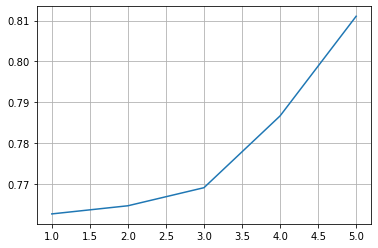

In [68]:

model = RandomForestRegressor(max_depth=20, max_features='log2', n_estimators=50)

cv = KFold(n_splits = 5, shuffle = True, random_state = 47)

score = cross_val_score(grid_search .best_estimator_, X, y, scoring = 'r2', cv = cv)
plt.plot(range(1, len(score)+1), score);
plt.grid()